In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
os.chdir('..')

In [2]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    precision_score,
    recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns

import pytorch_lightning as pl

from src.models.autoencoder import FraudDataModule, AutoEncoder

%load_ext autoreload
%autoreload 2

In [3]:
BEST_MODEL_PATH = 'logs/ae/checkpoints/autoencoder.ckpt'

In [4]:
dataset = pd.read_csv('data/creditcard.csv')

In [5]:
dm = FraudDataModule(
        dataset, 128, 128, 1, 4, drop_positive=True, target_name='Class', data_test=dataset
    )

In [6]:
dm.setup(stage='test')
dl = dm.test_dataloader()

In [23]:
model = AutoEncoder.load_from_checkpoint(BEST_MODEL_PATH)

In [24]:
trainer = pl.Trainer(accelerator='gpu',
        devices=1,)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
model.pred_losses

[]

In [26]:
trainer.predict(model, dl)

You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

[tensor(0.0150),
 tensor(0.0067),
 tensor(0.1053),
 tensor(0.0322),
 tensor(0.0607),
 tensor(0.0047),
 tensor(0.0093),
 tensor(0.0935),
 tensor(0.0182),
 tensor(0.0075),
 tensor(0.0179),
 tensor(0.0565),
 tensor(0.0131),
 tensor(0.0057),
 tensor(0.1200),
 tensor(0.0384),
 tensor(0.0093),
 tensor(0.0230),
 tensor(0.3293),
 tensor(0.0106),
 tensor(0.0188),
 tensor(0.0264),
 tensor(0.0323),
 tensor(0.1164),
 tensor(0.1851),
 tensor(0.0323),
 tensor(0.0082),
 tensor(0.0117),
 tensor(0.0072),
 tensor(0.0056),
 tensor(0.0069),
 tensor(0.0067),
 tensor(0.0178),
 tensor(0.0178),
 tensor(0.0253),
 tensor(0.0253),
 tensor(0.0107),
 tensor(0.0329),
 tensor(0.0120),
 tensor(0.0068),
 tensor(0.0201),
 tensor(0.0493),
 tensor(0.0121),
 tensor(0.0521),
 tensor(0.0357),
 tensor(0.0035),
 tensor(0.0984),
 tensor(0.1529),
 tensor(0.0445),
 tensor(0.0314),
 tensor(0.0568),
 tensor(0.4597),
 tensor(0.0602),
 tensor(0.0142),
 tensor(0.0127),
 tensor(0.0586),
 tensor(0.0780),
 tensor(0.0434),
 tensor(0.0033

In [27]:
losses = np.array(model.pred_losses)

In [29]:
losses = pd.DataFrame(losses, columns=['target', 'loss'])

In [30]:
losses

,target,loss
0,0.0,0.015026
1,0.0,0.006715
2,0.0,0.105320
3,0.0,0.032243
4,0.0,0.060671
...,...,...
284802,0.0,0.207670
284803,0.0,0.061063
284804,0.0,0.013661
284805,0.0,0.069820


In [37]:
losses[losses['target'] == 1]['loss'].describe()

count    492.000000
mean       8.366230
std       13.957790
min        0.007194
25%        0.788513
50%        2.406567
75%        8.042915
max       69.996971
Name: loss, dtype: float64

In [41]:
def get_optimum_threshold(y_true, y_pred_proba):
    precisions, recalls, trs = precision_recall_curve(
        y_true, y_pred_proba
    )
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    print(f1_scores.max())
    plt.plot(precisions, recalls)
    plt.show()

    return trs[np.argmax(f1_scores)]

In [42]:
y_true = losses['target'].values.astype(np.int32)

0.49951219462275126


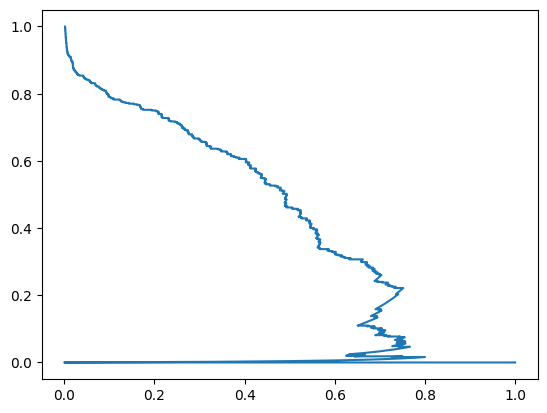

In [43]:
tr = get_optimum_threshold(y_true, losses['loss'])

In [44]:
tr

2.263676643371582